In [1]:
from IPython.display import display
import misc
import matplotlib as mpl
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import copy
import scipy

from matplotlib import rcParams
from scipy.stats import pearsonr, fisher_exact
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
import sys
from sklearn.metrics import roc_auc_score

from misc import rename_cytokines, rename_CMs, rename_factors, rename_Y, make_annot, convert_partial_year, rename_blood, rename_pathways, get_phenotype_contrasts
from misc import coef_col, pval_col, padj_col
from bcg_utils import fisher_enrichment
import bcg_utils as utils

import anndata
import scanpy as sc
from bcg_utils import GAMMA, SMALL_DELTA

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)
sc.set_figure_params(vector_friendly=True, dpi_save=DPI) 
sc.set_figure_params(scanpy=True, fontsize=6)

FIG_SIZE = (1.25, 1.25)
HEATMAP_SIZE = (0.3, 0.3)
CIRCLE_SIZE = 20
CIRCLE_LINE_WIDTH = 0.4
ALPHA = 0.8
LGD_MARKER_SCALE = 1.2

# scRNAseq
RNA_FDR = 0.1
LFC_THR = 0
RNA_RESULTS_DIR = os.path.join('results', 'scRNAseq', 'with_log_counts')
SUBSAMPLE_SORTED_CELLS = True
EXP_FRAC = 0.2
CELLTYPES = ['PBMC', 'CD4+ T', 'CD8+ T', 'Monocytes', 'B cells', 'NK']

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure7')
data_dir = os.path.join('..', 'data', 'scRNAseq_YangLi')

In [3]:
model = 'scLM.subsampled'
interaction = False

# The first is needed to load "expFrac" data
de_RNA = misc.get_scRNAseq_results(RNA_RESULTS_DIR, model='t_test', celltype_cols=['PBMC', 'celltypist'], interaction=False, subsample_sorted_cells=False)
de_RNA = misc.get_scRNAseq_results(RNA_RESULTS_DIR, results=de_RNA, model=model.split('.')[0], celltype_cols=['PBMC', 'celltypist'], interaction=interaction, subsample_sorted_cells=SUBSAMPLE_SORTED_CELLS)
de_RNA[model].keys()

dict_keys(['PBMC', 'CD4+ T', 'CD8+ T', 'Monocytes', 'B cells', 'NK'])

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz


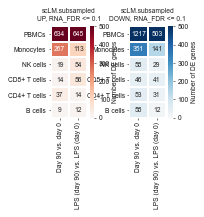

In [4]:
RNA_COEFS = [
    # RNA_LPS,
    RNA_D90,
    RNA_TRIM
]

peaks_df = misc.get_peak_annot(misc.PEAK_ANNOT_ALL_FN)
peaks_mask = utils.peaks_to_genes(peaks_df, **misc.PEAKS_TO_GENES[misc.GENE_AND_DISTAL_10kb])
peaks_df = peaks_df.loc[peaks_mask]

N_DEGs = {1: [], -1: []}
DEGS = {}
for direction in [1, -1]:
    n_degs = []
    DEGS[direction] = {}
    for celltype in CELLTYPES:
        DEGS[direction][celltype] = {}
        n_degs.append([])
        for coef in RNA_COEFS:
            if coef in de_RNA[model][celltype]['expFrac']:
                if celltype in ['PBMCs', 'PBMC']:
                    peaks_and_genes = peaks_df['gene_name'].copy()
                    peaks_and_genes = peaks_and_genes.str.split(', ', expand=True).stack().rename('gene_name')
                    peaks_and_genes.index = peaks_and_genes.index.get_level_values(0)
                    background = de_RNA[model][celltype]["pval"][coef].index.intersection(set(peaks_and_genes))
                else:
                    background = de_RNA[model][celltype]['expFrac'][coef].index[de_RNA[model][celltype]['expFrac'][coef] > EXP_FRAC]
                # print(celltype, 'background', len(background))

                padj = misc.adjusted_pvals(de_RNA[model][celltype]["pval"].loc[background, coef])
                coefs = de_RNA[model][celltype]['coef'].loc[background, coef]
                assert padj.index.equals(coefs.index)

                coefs = coefs.loc[coefs * direction > 0]
                padj = padj.loc[coefs.index]
                DEGS[direction][celltype][coef] = padj.index[((padj <= RNA_FDR) & (coefs.abs() >= LFC_THR))]
                n_degs[-1].append(len(DEGS[direction][celltype][coef]))
            else:
                n_degs[-1].append(np.nan)

    N_DEGs[direction] = n_degs

fig, axs = plt.subplots(1, 2, figsize=(2, len(CELLTYPES) / 4))
plt.subplots_adjust(wspace=0.7)

order = np.argsort(np.asarray(np.nan_to_num(N_DEGs[1], nan=0) + np.nan_to_num(N_DEGs[-1], nan=0)).sum(axis=1))[::-1]
for ax, direction in zip(axs, N_DEGs.keys()):
    N_DEGs[direction] = np.asarray(N_DEGs[direction])
    ax = sns.heatmap(N_DEGs[direction][order], vmin=0, vmax=500, annot=True, fmt='.5g',
                     cbar_kws=dict(label='Number of DE genes'), lw=1, ax=ax,
                    cmap='RdBu_r' if direction > 0 else 'RdBu', center=0)
    ax.set_xticklabels(RNA_COEFS, rotation=90)
    ax.set_yticklabels(['PBMCs' if c == 'PBMC' else f'{c} cells' if c[-1] != 's' else c for c in np.asarray(CELLTYPES)[order]], rotation=0)
    ax.set_title(f'{model}\n{"UP" if direction > 0 else "DOWN"}, RNA_FDR <= {RNA_FDR}{f" & |LFC| > {LFC_THR:.2g}" if LFC_THR != 0 else ""}')
utils.savefig(os.path.join(fig_dir, 'scRNAseq_N_DEGs.svg'), dpi=300)
plt.show()

In [5]:
adata = anndata.read_h5ad(os.path.join(data_dir, 'bcg0712_complete.QC2.SCT_log_counts.UMAP.QC3.celltypes.empty.h5ad'))
adata.X = scipy.sparse.csr_matrix(adata.shape)

adata.obs['celltypist'] = adata.obs['celltypist'].astype(str)
for c in ['HSC/MPP', 'MAIT cells', 'Plasma cells', 'Other']:
    adata.obs.loc[adata.obs['celltypist'] == c, 'celltypist'] = 'z.other'
adata.obs.loc[adata.obs['celltypist'] == 'DC', 'celltypist'] = 'a.DC'
adata.obs.loc[adata.obs['celltypist'] == 'Monocytes', 'celltypist'] = 'A.Monocytes'
adata.obs.loc[adata.obs['celltypist'] == 'Non-classical monocytes', 'celltypist'] = 'A.Non-classical monocytes'

adata.obs.loc[adata.obs['celltypist'] == 'Tregs', 'celltypist'] = 'T regulatory cells'
adata.obs.loc[adata.obs['celltypist'] == 'CRTAM+ gamma-delta T cells', 'celltypist'] = f'T CRTAM+ {GAMMA}{SMALL_DELTA} cells'
adata.obs.loc[adata.obs['celltypist'] == 'CD4+ T', 'celltypist'] = 'T CD4+ cells'
adata.obs.loc[adata.obs['celltypist'] == 'CD8+ T', 'celltypist'] = 'T CD8+ cells'

adata.obs['stim'] = adata.obs['stim'].astype(str)
adata.obs.loc[adata.obs['stim'] == 'RPMI', 'stim'] = 'Control'

random_indices=np.random.permutation(list(range(adata.shape[0])))

/home/lfolkman/miniconda3/envs/BCG/lib/python3.6/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'stim' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltypist' as categorical
No handles with labels found to put in legend.
Trying to set attribute `.obs` of view, copying.
... storing 'stim' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltypist' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'stim' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltypist' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'stim' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltypist' as categorical
Trying to set attribute `.obs` of view, copying.
..

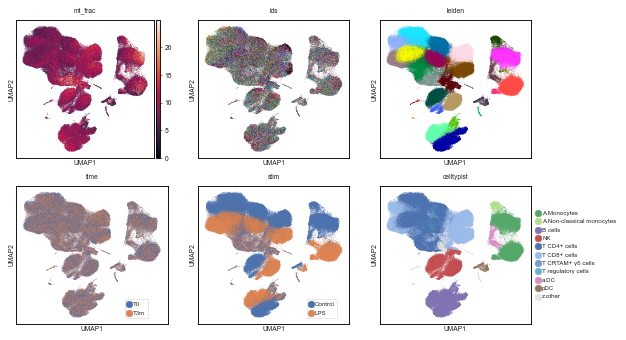

<Figure size 320x320 with 0 Axes>

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(8.25, 5))

axs = axs.flatten()
for i, color in enumerate(['mt_frac', 'ids', 'leiden']):
    sc.pl.umap(adata[random_indices, :], ax=axs[i], color=color, show=False)
    axs[i].legend().set_visible(False)
for i, color in enumerate(['time', 'stim']):
    sc.pl.umap(adata[random_indices, :], ax=axs[3 + i], color=color, palette=[BLUE, ORANGE], show=False)
    axs[3 + i].legend(bbox_to_anchor=(0.7, 0.2))
sc.pl.umap(adata[random_indices, :], ax=axs[-1], color='celltypist',
           palette=[GREEN, LIGHT_GREEN, PURPLE, RED, BLUE, LIGHT_BLUE, MIDDLE_BLUE, CYAN, PINK, BROWN, SUPER_LIGHT_GRAY])
sns.despine()
utils.savefig(os.path.join(fig_dir, 'scRNAseq_umap_all_QC.svg'), fig=fig, dpi=DPI)

Trying to set attribute `.obs` of view, copying.
... storing 'stim' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltypist' as categorical


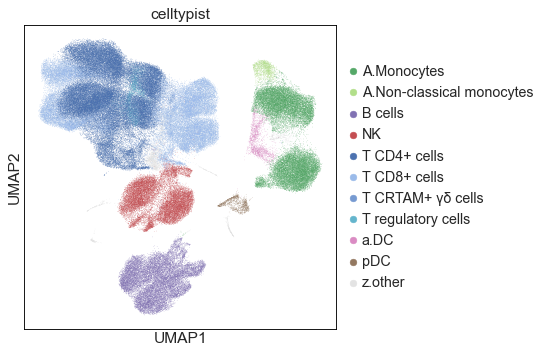

In [7]:
sc.set_figure_params(vector_friendly=True, dpi_save=50)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sc.pl.umap(adata[random_indices, :], ax=ax, color='celltypist',
           palette=[GREEN, LIGHT_GREEN, PURPLE, RED, BLUE, LIGHT_BLUE, MIDDLE_BLUE, CYAN, PINK, BROWN, SUPER_LIGHT_GRAY],
          )
utils.savefig(os.path.join(fig_dir, 'scRNAseq_umap_celltypes.svg'), fig=fig, dpi=50)

In [8]:
RENAME = {
    'T0_RPMI': 'Unstimulated, day 0',
    'T0_LPS': 'LPS-stimulated, day 0',
    'T3m_RPMI': 'Unstimulated, day 90',
    'T3m_LPS': 'LPS-stimulated, day 90'
}

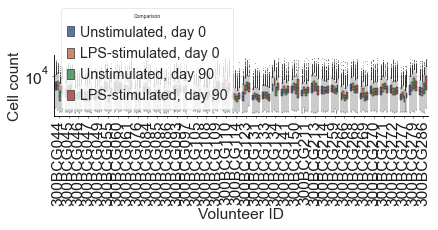

In [9]:
df = adata.obs[['ids', 'n_counts', 'ts']].copy()
df['ts'] = df['ts'].map(RENAME)

fig, ax = plt.subplots(1, 1, figsize=(6., 1))
sns.boxplot(data=df, x='ids', y='n_counts', hue='ts', palette=[BLUE, ORANGE, GREEN, RED],
            flierprops=dict(markerfacecolor='k', marker='.', markersize=1, markeredgewidth=0.0, rasterized=True),
            hue_order=list(RENAME.values()), ax=ax)
plt.setp(ax.artists, edgecolor='k', lw=0.4)
plt.setp(ax.lines, color='k', lw=0.4)
ax.tick_params(axis='x', labelrotation=90)
ax.set_yscale('log')
ax.set_xlabel('Volunteer ID')
ax.set_ylabel('Cell count')
ax.legend(title='Comparison')
sns.despine()
utils.savefig(os.path.join(fig_dir, 'scRNAseq_n_counts.svg'), fig=fig, dpi=DPI)
plt.show()

### Suppl. Tables

In [3]:
RNA_STATS = 'S0X_scRNAseq_STATS'

SAVE_TABLES = True
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables([RNA_STATS], modes=['w']) # 
    
data_dir = os.path.join('..', 'data', 'scRNAseq_YangLi')
adata = anndata.read_h5ad(os.path.join(data_dir, 'bcg0712_complete.QC2.SCT_log_counts.UMAP.QC3.celltypes.empty.h5ad'))
suppl_df = adata.obs[['ids', 'time', 'stim', 'celltypist', 'PBMC', 'n_counts', 'n_genes', 'mt_frac', 'batch']].copy()
suppl_df.index.name = 'Barcode'
suppl_df = suppl_df.rename(dict(
    ids='Donor', time='Time point', stim='Stimulus', celltypist='Cell type', PBMC='PBMC', n_counts='Counts',
    n_genes='Number of detected genes', mt_frac='Mitochondrial count fraction', batch='Batch ID'
), axis=1)
suppl_df['Counts'] = suppl_df['Counts'].astype(int)
suppl_df['Time point'] = suppl_df['Time point'].str.replace('T0', 'd0').str.replace('T3m', 'd90')
assert set(suppl_df['Time point']) == set(['d0', 'd90'])
assert set(suppl_df['PBMC'].astype(str)) == set(['PBMC', 'nan'])
suppl_df['PBMC'] = suppl_df['PBMC'].astype(str) == 'PBMC'
assert set(suppl_df.loc[~suppl_df['PBMC'], 'Cell type']) == set(['Other'])

sheet_name = 'scRNAseq_statistics'
table_name = RNA_STATS
suppl_tables[table_name]['info'][sheet_name] = f'The scRNA-seq sample-level quality statistics and annotation{misc.related_to_fig_str("S")}.'
suppl_tables[table_name]['header_rows'][sheet_name] = len(suppl_df.columns.names)
suppl_tables[table_name]['index_cols'][sheet_name] = len(suppl_df.index.names)
misc.save_excel(suppl_df, suppl_tables[table_name]['file'], sheet_name=sheet_name)
display(suppl_df)

if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)
misc.fix_font_for_suppl_tables(suppl_tables)

,Donor,Time point,Stimulus,Cell type,PBMC,Counts,Number of detected genes,Mitochondrial count fraction,Batch ID
Barcode,,,,,,,,,
AAACCCAAGTCTAGAA-1_1_1,300BCG044,d0,RPMI,CD4+ T,True,9363,3268,5.145129,b1
AAACCCACAATTTCCT-1_1_1,300BCG044,d0,RPMI,CD4+ T,True,8343,2882,6.944677,b1
AAACGAACAGCGTTTA-1_1_1,300BCG055,d0,RPMI,CD8+ T,True,6959,2799,5.496966,b1
AAACGAAGTCGCATGC-1_1_1,300BCG055,d0,RPMI,Monocytes,True,4662,1832,4.114146,b1
AAACGAATCGGAATGG-1_1_1,300BCG044,d0,RPMI,B cells,True,8321,2689,5.035550,b1
...,...,...,...,...,...,...,...,...,...
TTTGTTGAGATCACCT-1_12_3,300BCG269,d90,LPS,CD4+ T,True,2377,1280,5.029338,b3
TTTGTTGCACACAGAG-1_12_3,300BCG269,d90,LPS,CD8+ T,True,3366,1491,5.942806,b3
TTTGTTGGTCAAGCCC-1_12_3,300BCG131,d90,LPS,CD4+ T,True,1736,970,7.802198,b3


S0X_scRNAseq_STATS


,Contents
Sheet name,
scRNAseq_statistics,The scRNA-seq sample-level quality statistics ...
